In [1]:
from zipfile import ZipFile
import os
import urllib
import urllib.request

FILE = 'fashion_mnist_images.zip'
FOLDER = 'fashion_mnist_images'
URL = 'https://nnfs.io/datasets/fashion_mnist_images.zip'


if not os.path.isfile(FILE):
    print(f'Downloading {URL} and saving as {FILE}...')
    urllib.request.urlretrieve(URL, FILE)
print('Unzipping images...')

with ZipFile(FILE) as zip_images:
    zip_images.extractall(FOLDER)
print('Done!')

Unzipping images...
Done!


In [2]:
'''
The following code is from the Neural Networks from Scratch book by Harrison Kinsley and Daniel Kukiela.

https://nnfs.io
'''

import numpy as np
import os
import cv2
from tqdm import tqdm
import pickle
import copy
import pickle

# We'll be saving all the data from this model's training. 
train_dict = {}

# Dense layer
class Layer_Dense:

    # Layer initialization
    def __init__(self, n_inputs, n_neurons,
                 weight_regularizer_l1=0, weight_regularizer_l2=0,
                 bias_regularizer_l1=0, bias_regularizer_l2=0):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        # Set regularization strength
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    # Forward pass
    def forward(self, inputs, training):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)


        # Gradients on regularization
        # L1 on weights
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1
        # L2 on weights
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * \
                             self.weights
        # L1 on biases
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1
        # L2 on biases
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * \
                            self.biases

        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)


# Dropout
class Layer_Dropout:

    # Init
    def __init__(self, rate):
        # Store rate, we invert it as for example for dropout
        # of 0.1 we need success rate of 0.9
        self.rate = 1 - rate

    # Forward pass
    def forward(self, inputs, training):
        # Save input values
        self.inputs = inputs

        # If not in the training mode - return values
        if not training:
            self.output = inputs.copy()
            return

        # Generate and save scaled mask
        self.binary_mask = np.random.binomial(1, self.rate,
                           size=inputs.shape) / self.rate
        # Apply mask to output values
        self.output = inputs * self.binary_mask


    # Backward pass
    def backward(self, dvalues):
        # Gradient on values
        self.dinputs = dvalues * self.binary_mask


# Input "layer"
class Layer_Input:

    # Forward pass
    def forward(self, inputs, training):
        self.output = inputs


# ReLU activation
class Activation_ReLU:

    # Forward pass
    def forward(self, inputs, training):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify original variable,
        # let's make a copy of values first
        self.dinputs = dvalues.copy()

        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0

    # Calculate predictions for outputs
    def predictions(self, outputs):
        return outputs


# Softmax activation
class Activation_Softmax:

    # Forward pass
    def forward(self, inputs, training):
        # Remember input values
        self.inputs = inputs

        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1,
                                            keepdims=True))

        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1,
                                            keepdims=True)

        self.output = probabilities

    # Backward pass
    def backward(self, dvalues):

        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in \
                enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - \
                              np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix,
                                         single_dvalues)

    # Calculate predictions for outputs
    def predictions(self, outputs):
        return np.argmax(outputs, axis=1)



# Adam optimizer
class Optimizer_Adam:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,
                 beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2


    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update momentum  with current gradients
        layer.weight_momentums = self.beta_1 * \
                                 layer.weight_momentums + \
                                 (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * \
                               layer.bias_momentums + \
                               (1 - self.beta_1) * layer.dbiases
        # Get corrected momentum
        # self.iteration is 0 at first pass
        # and we need to start with 1 here
        weight_momentums_corrected = layer.weight_momentums / \
            (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / \
            (1 - self.beta_1 ** (self.iterations + 1))
        # Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + \
            (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + \
            (1 - self.beta_2) * layer.dbiases**2
        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         weight_momentums_corrected / \
                         (np.sqrt(weight_cache_corrected) +
                             self.epsilon)

        layer.biases += -self.current_learning_rate * \
                         bias_momentums_corrected / \
                         (np.sqrt(bias_cache_corrected) +
                             self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# Common loss class
class Loss:

    # Regularization loss calculation
    def regularization_loss(self):

        # 0 by default
        regularization_loss = 0

        # Calculate regularization loss
        # iterate all trainable layers
        for layer in self.trainable_layers:

            # L1 regularization - weights
            # calculate only when factor greater than 0
            if layer.weight_regularizer_l1 > 0:
                regularization_loss += layer.weight_regularizer_l1 * \
                                       np.sum(np.abs(layer.weights))

            # L2 regularization - weights
            if layer.weight_regularizer_l2 > 0:
                regularization_loss += layer.weight_regularizer_l2 * \
                                       np.sum(layer.weights * \
                                              layer.weights)

            # L1 regularization - biases
            # calculate only when factor greater than 0
            if layer.bias_regularizer_l1 > 0:
                regularization_loss += layer.bias_regularizer_l1 * \
                                       np.sum(np.abs(layer.biases))

            # L2 regularization - biases
            if layer.bias_regularizer_l2 > 0:
                regularization_loss += layer.bias_regularizer_l2 * \
                                       np.sum(layer.biases * \
                                              layer.biases)

        return regularization_loss


    # Set/remember trainable layers
    def remember_trainable_layers(self, trainable_layers):
        self.trainable_layers = trainable_layers

    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y, *, include_regularization=False):

        # Calculate sample losses
        sample_losses = self.forward(output, y)

        # Calculate mean loss
        data_loss = np.mean(sample_losses)

        # Add accumulated sum of losses and sample count
        self.accumulated_sum += np.sum(sample_losses)
        self.accumulated_count += len(sample_losses)

        # If just data loss - return it
        if not include_regularization:
            return data_loss

        # Return the data and regularization losses
        return data_loss, self.regularization_loss()

    # Calculates accumulated loss
    def calculate_accumulated(self, *, include_regularization=False):

        # Calculate mean loss
        data_loss = self.accumulated_sum / self.accumulated_count

        # If just data loss - return it
        if not include_regularization:
            return data_loss

        # Return the data and regularization losses
        return data_loss, self.regularization_loss()

    # Reset variables for accumulated loss
    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0



# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss):

    # Forward pass
    def forward(self, y_pred, y_true):

        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]

        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )

        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples

# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy():

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)

        # If labels are one-hot encoded,
        # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples



# Common accuracy class
class Accuracy:

    # Calculates an accuracy
    # given predictions and ground truth values
    def calculate(self, predictions, y):

        # Get comparison results
        comparisons = self.compare(predictions, y)

        # Calculate an accuracy
        accuracy = np.mean(comparisons)

        # Add accumulated sum of matching values and sample count
        self.accumulated_sum += np.sum(comparisons)
        self.accumulated_count += len(comparisons)

        # Return accuracy
        return accuracy

    # Calculates accumulated accuracy
    def calculate_accumulated(self):

        # Calculate an accuracy
        accuracy = self.accumulated_sum / self.accumulated_count

        # Return the data and regularization losses
        return accuracy

    # Reset variables for accumulated accuracy
    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0


# Accuracy calculation for classification model
class Accuracy_Categorical(Accuracy):

    def __init__(self, *, binary=False):
        # Binary mode?
        self.binary = binary

    # No initialization is needed
    def init(self, y):
        pass

    # Compares predictions to the ground truth values
    def compare(self, predictions, y):
        if not self.binary and len(y.shape) == 2:
            y = np.argmax(y, axis=1)
        return predictions == y


# Model class
class Model:

    def __init__(self):
        # Create a list of network objects
        self.layers = []
        # Softmax classifier's output object
        self.softmax_classifier_output = None

    # Add objects to the model
    def add(self, layer):
        self.layers.append(layer)


    # Set loss, optimizer and accuracy
    def set(self, *, loss=None, optimizer=None, accuracy=None):

        if loss is not None:
            self.loss = loss

        if optimizer is not None:
            self.optimizer = optimizer

        if accuracy is not None:
            self.accuracy = accuracy

    # Finalize the model
    def finalize(self):

        # Create and set the input layer
        self.input_layer = Layer_Input()

        # Count all the objects
        layer_count = len(self.layers)

        # Initialize a list containing trainable layers:
        self.trainable_layers = []

        # Iterate the objects
        for i in range(layer_count):

            # If it's the first layer,
            # the previous layer object is the input layer
            if i == 0:
                self.layers[i].prev = self.input_layer
                self.layers[i].next = self.layers[i+1]

            # All layers except for the first and the last
            elif i < layer_count - 1:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.layers[i+1]

            # The last layer - the next object is the loss
            # Also let's save aside the reference to the last object
            # whose output is the model's output
            else:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.loss
                self.output_layer_activation = self.layers[i]


            # If layer contains an attribute called "weights",
            # it's a trainable layer -
            # add it to the list of trainable layers
            # We don't need to check for biases -
            # checking for weights is enough
            if hasattr(self.layers[i], 'weights'):
                self.trainable_layers.append(self.layers[i])

        # Update loss object with trainable layers
        if self.loss is not None:
            self.loss.remember_trainable_layers(
                self.trainable_layers
            )

        # If output activation is Softmax and
        # loss function is Categorical Cross-Entropy
        # create an object of combined activation
        # and loss function containing
        # faster gradient calculation
        if isinstance(self.layers[-1], Activation_Softmax) and \
           isinstance(self.loss, Loss_CategoricalCrossentropy):
            # Create an object of combined activation
            # and loss functions
            self.softmax_classifier_output = \
                Activation_Softmax_Loss_CategoricalCrossentropy()

    # Train the model
    def train(self, X, y, *, epochs=1, batch_size=None,
              print_every=1, validation_data=None):

        # Initialize accuracy object
        self.accuracy.init(y)

        # Default value if batch size is not being set
        train_steps = 1

        # Calculate number of steps
        if batch_size is not None:
            train_steps = len(X) // batch_size
            # Dividing rounds down. If there are some remaining
            # data but not a full batch, this won't include it
            # Add `1` to include this not full batch
            if train_steps * batch_size < len(X):
                train_steps += 1

        
        # Main training loop
        for epoch in range(1, epochs+1):
            train_dict[epoch] = {}  # add this
            
            # Print epoch number
            print(f'epoch: {epoch}')

            # Reset accumulated values in loss and accuracy objects
            self.loss.new_pass()
            self.accuracy.new_pass()

            
            # Iterate over steps
            for step in range(train_steps):
                train_dict[epoch][step] = {} # add this
                # If batch size is not set -
                # train using one step and full dataset
                if batch_size is None:
                    batch_X = X
                    batch_y = y

                # Otherwise slice a batch
                else:
                    batch_X = X[step*batch_size:(step+1)*batch_size]
                    batch_y = y[step*batch_size:(step+1)*batch_size]

                # Perform the forward pass
                output = self.forward(batch_X, training=True)

                # Calculate loss
                data_loss, regularization_loss = \
                    self.loss.calculate(output, batch_y,
                                        include_regularization=True)
                loss = data_loss + regularization_loss

                # Get predictions and calculate an accuracy
                predictions = self.output_layer_activation.predictions(
                                  output)
                accuracy = self.accuracy.calculate(predictions,
                                                   batch_y)

                # Perform backward pass
                self.backward(output, batch_y)

                # Optimize (update parameters)
                ########################################################
                ### THIS IS WHERE WE SAVE ALL THE DATA FROM TRAINING ###
                ########################################################
                self.optimizer.pre_update_params()
                for n, layer in enumerate(self.trainable_layers):  # added enum/n
                    self.optimizer.update_params(layer)
                    train_dict[epoch][step][n] = {}
                    train_dict[epoch][step][n]["weights"] = layer.weights.copy()
                    train_dict[epoch][step][n]["biases"] = layer.biases.copy()
                    train_dict[epoch][step][n]["dweights"] = layer.dweights.copy()
                    train_dict[epoch][step][n]["dbiases"] = layer.dbiases.copy()
                    train_dict[epoch][step][n]["weight_momentums"] = layer.weight_momentums.copy()
                    train_dict[epoch][step][n]["bias_momentums"] = layer.bias_momentums.copy()

                self.optimizer.post_update_params()

                # Print a summary
                if not step % print_every or step == train_steps - 1:
                    print(f'step: {step}, ' +
                          f'acc: {accuracy:.3f}, ' +
                          f'loss: {loss:.3f} (' +
                          f'data_loss: {data_loss:.3f}, ' +
                          f'reg_loss: {regularization_loss:.3f}), ' +
                          f'lr: {self.optimizer.current_learning_rate}')

            # Get and print epoch loss and accuracy
            epoch_data_loss, epoch_regularization_loss = \
                self.loss.calculate_accumulated(
                    include_regularization=True)
            epoch_loss = epoch_data_loss + epoch_regularization_loss
            epoch_accuracy = self.accuracy.calculate_accumulated()

            print(f'training, ' +
                  f'acc: {epoch_accuracy:.3f}, ' +
                  f'loss: {epoch_loss:.3f} (' +
                  f'data_loss: {epoch_data_loss:.3f}, ' +
                  f'reg_loss: {epoch_regularization_loss:.3f}), ' +
                  f'lr: {self.optimizer.current_learning_rate}')

            # If there is the validation data
            if validation_data is not None:

                # Evaluate the model:
                self.evaluate(*validation_data,
                              batch_size=batch_size)

    # Evaluates the model using passed-in dataset
    def evaluate(self, X_val, y_val, *, batch_size=None):

        # Default value if batch size is not being set
        validation_steps = 1

        # Calculate number of steps
        if batch_size is not None:
            validation_steps = len(X_val) // batch_size
            # Dividing rounds down. If there are some remaining
            # data but not a full batch, this won't include it
            # Add `1` to include this not full batch
            if validation_steps * batch_size < len(X_val):
                validation_steps += 1

        # Reset accumulated values in loss
        # and accuracy objects
        self.loss.new_pass()
        self.accuracy.new_pass()


        # Iterate over steps
        for step in range(validation_steps):

            # If batch size is not set -
            # train using one step and full dataset
            if batch_size is None:
                batch_X = X_val
                batch_y = y_val

            # Otherwise slice a batch
            else:
                batch_X = X_val[
                    step*batch_size:(step+1)*batch_size
                ]
                batch_y = y_val[
                    step*batch_size:(step+1)*batch_size
                ]

            # Perform the forward pass
            output = self.forward(batch_X, training=False)

            # Calculate the loss
            self.loss.calculate(output, batch_y)

            # Get predictions and calculate an accuracy
            predictions = self.output_layer_activation.predictions(
                              output)
            self.accuracy.calculate(predictions, batch_y)

        # Get and print validation loss and accuracy
        validation_loss = self.loss.calculate_accumulated()
        validation_accuracy = self.accuracy.calculate_accumulated()

        # Print a summary
        print(f'validation, ' +
              f'acc: {validation_accuracy:.3f}, ' +
              f'loss: {validation_loss:.3f}')

    # Predicts on the samples
    def predict(self, X, *, batch_size=None):

        # Default value if batch size is not being set
        prediction_steps = 1

        # Calculate number of steps
        if batch_size is not None:
            prediction_steps = len(X) // batch_size

            # Dividing rounds down. If there are some remaining
            # data but not a full batch, this won't include it
            # Add `1` to include this not full batch
            if prediction_steps * batch_size < len(X):
                prediction_steps += 1

        # Model outputs
        output = []

        # Iterate over steps
        for step in range(prediction_steps):

            # If batch size is not set -
            # train using one step and full dataset
            if batch_size is None:
                batch_X = X

            # Otherwise slice a batch
            else:
                batch_X = X[step*batch_size:(step+1)*batch_size]

            # Perform the forward pass
            batch_output = self.forward(batch_X, training=False)

            # Append batch prediction to the list of predictions
            output.append(batch_output)

        # Stack and return results
        return np.vstack(output)

    # Performs forward pass
    def forward(self, X, training):

        # Call forward method on the input layer
        # this will set the output property that
        # the first layer in "prev" object is expecting
        self.input_layer.forward(X, training)

        # Call forward method of every object in a chain
        # Pass output of the previous object as a parameter
        for layer in self.layers:
            layer.forward(layer.prev.output, training)

        # "layer" is now the last object from the list,
        # return its output
        return layer.output


    # Performs backward pass
    def backward(self, output, y):

        # If softmax classifier
        if self.softmax_classifier_output is not None:
            # First call backward method
            # on the combined activation/loss
            # this will set dinputs property
            self.softmax_classifier_output.backward(output, y)

            # Since we'll not call backward method of the last layer
            # which is Softmax activation
            # as we used combined activation/loss
            # object, let's set dinputs in this object
            self.layers[-1].dinputs = \
                self.softmax_classifier_output.dinputs

            # Call backward method going through
            # all the objects but last
            # in reversed order passing dinputs as a parameter
            for layer in reversed(self.layers[:-1]):
                layer.backward(layer.next.dinputs)

            return

        # First call backward method on the loss
        # this will set dinputs property that the last
        # layer will try to access shortly
        self.loss.backward(output, y)

        # Call backward method going through all the objects
        # in reversed order passing dinputs as a parameter
        for layer in reversed(self.layers):
            layer.backward(layer.next.dinputs)

    # Retrieves and returns parameters of trainable layers
    def get_parameters(self):

        # Create a list for parameters
        parameters = []

        # Iterable trainable layers and get their parameters
        for layer in self.trainable_layers:
            parameters.append(layer.get_parameters())

        # Return a list
        return parameters


    # Updates the model with new parameters
    def set_parameters(self, parameters):

        # Iterate over the parameters and layers
        # and update each layers with each set of the parameters
        for parameter_set, layer in zip(parameters,
                                        self.trainable_layers):
            layer.set_parameters(*parameter_set)

    # Saves the parameters to a file
    def save_parameters(self, path):

        # Open a file in the binary-write mode
        # and save parameters into it
        with open(path, 'wb') as f:
            pickle.dump(self.get_parameters(), f)

    # Loads the weights and updates a model instance with them
    def load_parameters(self, path):

        # Open file in the binary-read mode,
        # load weights and update trainable layers
        with open(path, 'rb') as f:
            self.set_parameters(pickle.load(f))

    # Saves the model
    def save(self, path):

        # Make a deep copy of current model instance
        model = copy.deepcopy(self)

        # Reset accumulated values in loss and accuracy objects
        model.loss.new_pass()
        model.accuracy.new_pass()

        # Remove data from the input layer
        # and gradients from the loss object
        model.input_layer.__dict__.pop('output', None)
        model.loss.__dict__.pop('dinputs', None)

        # For each layer remove inputs, output and dinputs properties
        for layer in model.layers:
            for property in ['inputs', 'output', 'dinputs',
                             'dweights', 'dbiases']:
                layer.__dict__.pop(property, None)

        # Open a file in the binary-write mode and save the model
        with open(path, 'wb') as f:
            pickle.dump(model, f)


    # Loads and returns a model
    @staticmethod
    def load(path):

        # Open file in the binary-read mode, load a model
        with open(path, 'rb') as f:
            model = pickle.load(f)

        # Return a model
        return model


# Loads a MNIST dataset
def load_mnist_dataset(dataset, path):

    # Scan all the directories and create a list of labels
    labels = os.listdir(os.path.join(path, dataset))

    # Create lists for samples and labels
    X = []
    y = []


    # For each label folder
    for label in labels:
        print(label)
        # And for each image in given folder
        for file in tqdm(os.listdir(os.path.join(path, dataset, label))):
            # Read the image
            image = cv2.imread(
                        os.path.join(path, dataset, label, file),
                        cv2.IMREAD_UNCHANGED)

            # And append it and a label to the lists
            X.append(image)
            y.append(label)

    # Convert the data to proper numpy arrays and return
    return np.array(X), np.array(y).astype('uint8')


# MNIST dataset (train + test)
def create_data_mnist(path):

    # Load both sets separately
    X, y = load_mnist_dataset('train', path)
    X_test, y_test = load_mnist_dataset('test', path)

    # And return all the data
    return X, y, X_test, y_test


# Create dataset
X, y, X_test, y_test = create_data_mnist('fashion_mnist_images')
# Shuffle the training dataset
keys = np.array(range(X.shape[0]))
np.random.shuffle(keys)
X = X[keys]
y = y[keys]

# Scale and reshape samples
X = (X.reshape(X.shape[0], -1).astype(np.float32) - 127.5) / 127.5
X_test = (X_test.reshape(X_test.shape[0], -1).astype(np.float32) -
             127.5) / 127.5


2


100%|██████████| 6000/6000 [00:00<00:00, 37790.72it/s]


7


100%|██████████| 6000/6000 [00:00<00:00, 48691.43it/s]


9


100%|██████████| 6000/6000 [00:00<00:00, 40631.59it/s]


0


100%|██████████| 6000/6000 [00:00<00:00, 40067.48it/s]


6


100%|██████████| 6000/6000 [00:00<00:00, 40872.92it/s]


1


100%|██████████| 6000/6000 [00:00<00:00, 45279.86it/s]


8


100%|██████████| 6000/6000 [00:00<00:00, 41338.74it/s]


5


100%|██████████| 6000/6000 [00:00<00:00, 49752.53it/s]


4


100%|██████████| 6000/6000 [00:00<00:00, 41319.80it/s]


3


100%|██████████| 6000/6000 [00:00<00:00, 43642.55it/s]


2


100%|██████████| 1000/1000 [00:00<00:00, 40473.45it/s]


7


100%|██████████| 1000/1000 [00:00<00:00, 50647.28it/s]


9


100%|██████████| 1000/1000 [00:00<00:00, 42869.89it/s]


0


100%|██████████| 1000/1000 [00:00<00:00, 40666.12it/s]


6


100%|██████████| 1000/1000 [00:00<00:00, 41848.46it/s]


1


100%|██████████| 1000/1000 [00:00<00:00, 45244.05it/s]


8


100%|██████████| 1000/1000 [00:00<00:00, 41719.42it/s]


5


100%|██████████| 1000/1000 [00:00<00:00, 49986.94it/s]


4


100%|██████████| 1000/1000 [00:00<00:00, 41086.39it/s]


3


100%|██████████| 1000/1000 [00:00<00:00, 44522.68it/s]


In [ ]:
# Instantiate the model
model = Model()

# Add layers
model.add(Layer_Dense(X.shape[1], 32))
model.add(Activation_ReLU())
model.add(Layer_Dense(32, 32))
model.add(Activation_ReLU())
model.add(Layer_Dense(32, 10))
model.add(Activation_Softmax())

# Set loss, optimizer and accuracy objects
model.set(
    loss=Loss_CategoricalCrossentropy(),
    optimizer=Optimizer_Adam(decay=1e-3),
    accuracy=Accuracy_Categorical()
)

# Finalize the model
model.finalize()

# Train the model
model.train(X, y, validation_data=(X_test, y_test),
            epochs=5, batch_size=128, print_every=100)

model.save("fashion_mnist.model")


print("train_dict", train_dict)

# save train_dict with pickle
with open("train_dict.pkl", "wb") as f:
    pickle.dump(train_dict, f)

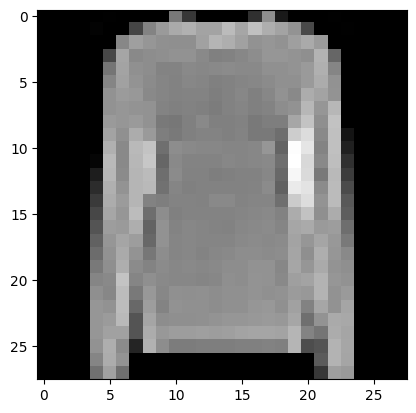

In [4]:
import matplotlib.pyplot as plt

plt.imshow(X_test[0].reshape(28, 28), cmap='gray')

In [5]:
model.predict(X_test[0])

array([[4.70531636e-03, 5.41777951e-04, 8.83540859e-01, 8.16187954e-04,
        2.14640914e-02, 8.24304912e-07, 8.86670823e-02, 1.96367371e-13,
        2.63861139e-04, 3.55740081e-13]])

In [6]:
np.argmax(model.predict(X_test[0]))

2

In [7]:
y_test[0]

2

In [8]:
for layer in model.layers:
    print(layer.output)

[[ 0.73031473  9.94960367 -2.62396729 -9.40176821 13.80971455  4.41039336
  13.09014814 20.07487582 19.00980729 -1.83716834  1.87804318  0.04611548
  18.24422008 -2.29907343 16.84477296  0.7622362   7.12559797 10.73549327
  -2.94898236  8.54532826  3.54305733  2.50031885  8.73248196 15.48889687
  -2.19272871 19.24893454  0.45226026 -1.67428888  4.17885255  2.57296301
   7.15467079 12.9128548 ]]
[[ 0.73031473  9.94960367  0.          0.         13.80971455  4.41039336
  13.09014814 20.07487582 19.00980729  0.          1.87804318  0.04611548
  18.24422008  0.         16.84477296  0.7622362   7.12559797 10.73549327
   0.          8.54532826  3.54305733  2.50031885  8.73248196 15.48889687
   0.         19.24893454  0.45226026  0.          4.17885255  2.57296301
   7.15467079 12.9128548 ]]
[[ 13.68453198   1.90025232  -3.55001515  -5.93403469  -8.60662476
   13.99314428  -2.85899497   9.80797599  -2.3255442   17.54134133
   15.15489741  14.02044433  14.06839002  -9.39385243   7.06290417
   

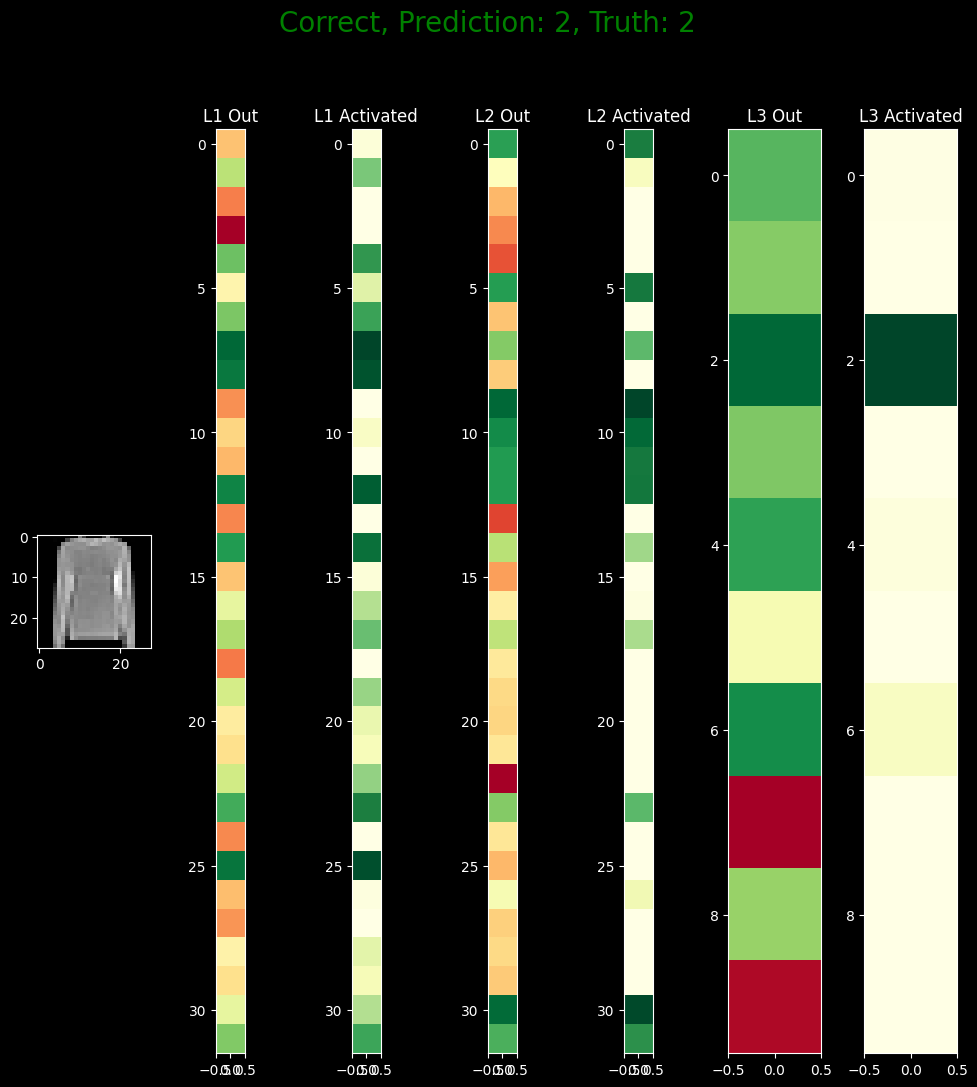

In [9]:
from matplotlib import style

style.use("dark_background")

def visualize_layers(sample_num, fig):
    input_data = X_test[sample_num]
    output_truth = y_test[sample_num]
    prediction = model.predict(input_data)

    if np.argmax(prediction) == output_truth:
        title_text = f"Correct, Prediction: {np.argmax(prediction)}, Truth: {output_truth}"
        fig.suptitle(title_text, color="g", fontsize=20)

    else:
        title_text = f"Incorrect, Prediction: {np.argmax(prediction)}, Truth: {output_truth}"
        fig.suptitle(title_text, color="r", fontsize=20)

    ax0 = plt.subplot2grid((1,7), (0,0), rowspan=1, colspan=1)
    ax1 = plt.subplot2grid((1,7), (0,1), rowspan=1, colspan=1)
    ax2 = plt.subplot2grid((1,7), (0,2), rowspan=1, colspan=1)
    ax3 = plt.subplot2grid((1,7), (0,3), rowspan=1, colspan=1)
    ax4 = plt.subplot2grid((1,7), (0,4), rowspan=1, colspan=1)
    ax5 = plt.subplot2grid((1,7), (0,5), rowspan=1, colspan=1)
    ax6 = plt.subplot2grid((1,7), (0,6), rowspan=1, colspan=1)

    ax0.imshow(input_data.reshape(28, 28), cmap='gray')

    layer_1 = np.rot90(model.layers[0].output, k=3, axes=(0,1))
    layer_1_activated = np.rot90(model.layers[1].output, k=3, axes=(0,1))

    ax1.imshow(layer_1, cmap='RdYlGn')#, aspect='auto')
    ax2.imshow(layer_1_activated, cmap='YlGn')#, aspect='auto')

    ax1.set_title("L1 Out")
    ax2.set_title("L1 Activated")

    layer_2 = np.rot90(model.layers[2].output, k=3, axes=(0,1))
    layer_2_activated = np.rot90(model.layers[3].output, k=3, axes=(0,1))

    ax3.imshow(layer_2, cmap='RdYlGn')#, aspect='auto')
    ax4.imshow(layer_2_activated, cmap='YlGn')#, aspect='auto')

    ax3.set_title("L2 Out")
    ax4.set_title("L2 Activated")

    layer_3 = np.rot90(model.layers[4].output, k=3, axes=(0,1))
    layer_3_activated = np.rot90(model.layers[5].output, k=3, axes=(0,1))

    ax5.imshow(layer_3, cmap='RdYlGn')#, aspect='auto')
    ax6.imshow(layer_3_activated, cmap='YlGn')#, aspect='auto')

    ax5.set_title("L3 Out")
    ax6.set_title("L3 Activated")

fig = plt.figure(figsize=(12, 12))
visualize_layers(0, fig)


In [10]:
%matplotlib tk

import os
from matplotlib import animation

LIMIT = 1000

d = "layer_outs"
if not os.path.exists(d):
    os.makedirs(d)

fig = plt.figure(figsize=(12, 12))

def animate(i):
    fig.clear()
    visualize_layers(i, fig)
    fig.savefig(f"{d}/{y_test[i]}-{i}.png")

ani = animation.FuncAnimation(fig, animate, frames=LIMIT, repeat=False)
plt.show()

In [ ]:
import cv2

# load the images
images = []
CLASS = 2
# display all the images in the "layer_outs" folder
for i in range(LIMIT):
    img = cv2.imread(f"layer_outs/{CLASS}-{i}.png")
    images.append(img)

#display the images
for img in images:
    try:
        cv2.imshow("Samples", img)
        cv2.waitKey(5)
    except:
        pass

cv2.destroyAllWindows()

In [13]:
from tqdm import tqdm

layer_data_by_class = {
                0: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
                1: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
                2: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
                3: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
                4: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
                5: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
                6: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
                7: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
                8: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
                9: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
                }

for data_n in tqdm(range(len(X_test))):
    model.predict(X_test[data_n])
    truth = y_test[data_n]

    '''# add layer data to dict:
    layer_data_by_class[truth][0].append(model.layers[0].output)
    layer_data_by_class[truth][1].append(model.layers[1].output)
    layer_data_by_class[truth][2].append(model.layers[2].output)
    layer_data_by_class[truth][3].append(model.layers[3].output)
    layer_data_by_class[truth][4].append(model.layers[4].output)
    layer_data_by_class[truth][5].append(model.layers[5].output)'''

    for layer_n, layer in enumerate(model.layers):
        layer_data_by_class[truth][layer_n].append(layer.output)

100%|██████████| 10000/10000 [00:00<00:00, 18846.74it/s]


In [16]:
layer_data_by_class_averages = {
                0: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
                1: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
                2: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
                3: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
                4: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
                5: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
                6: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
                7: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
                8: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
                9: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
                }

for class_n in range(10):
    for layer_n in range(6):
        layer_data_by_class_averages[class_n][layer_n] = np.mean(layer_data_by_class[class_n][layer_n], axis=0)

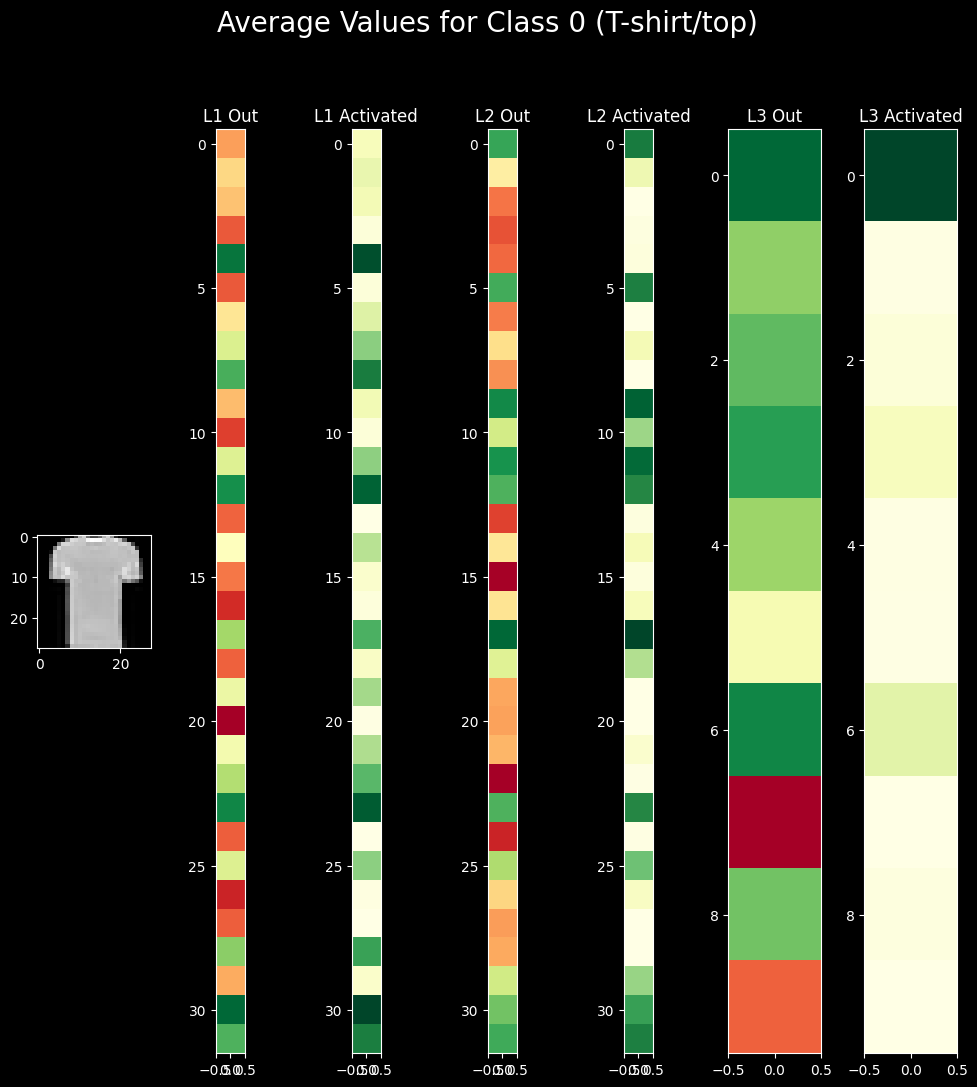

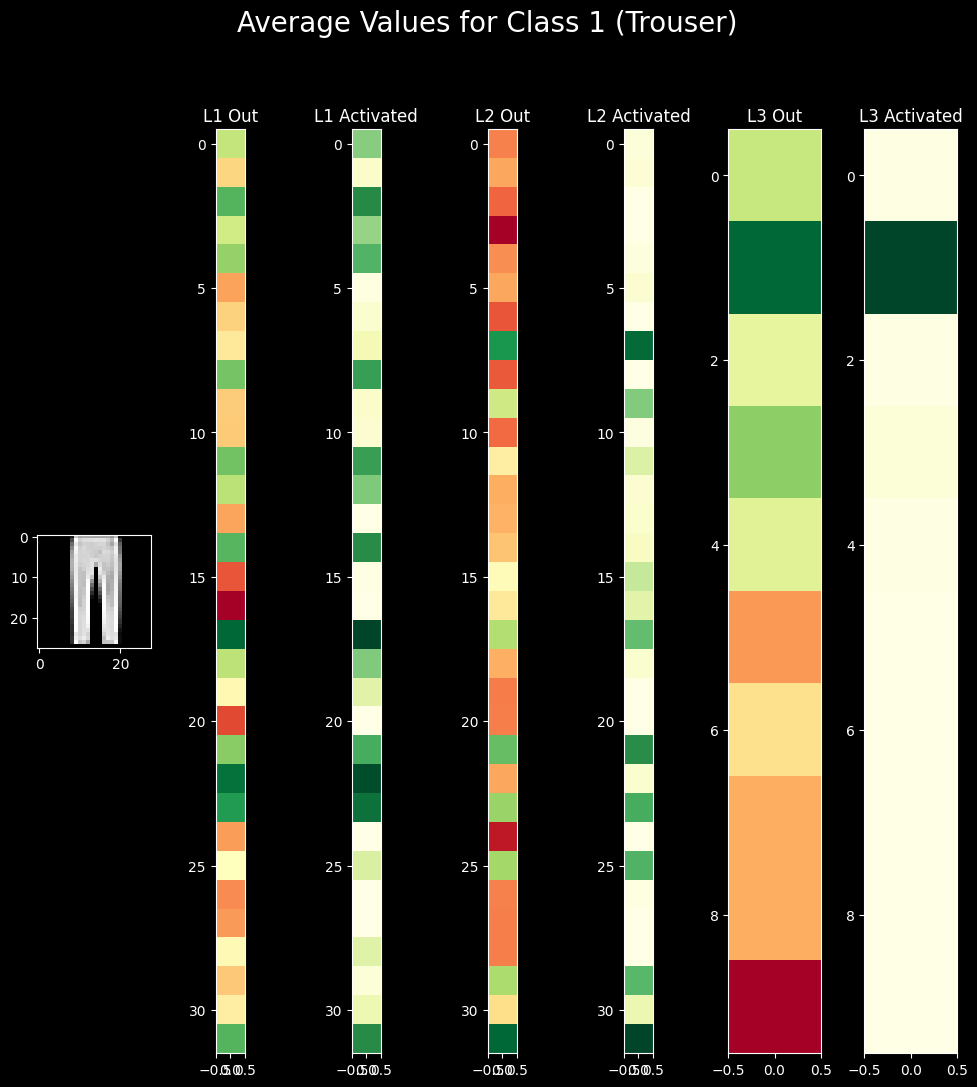

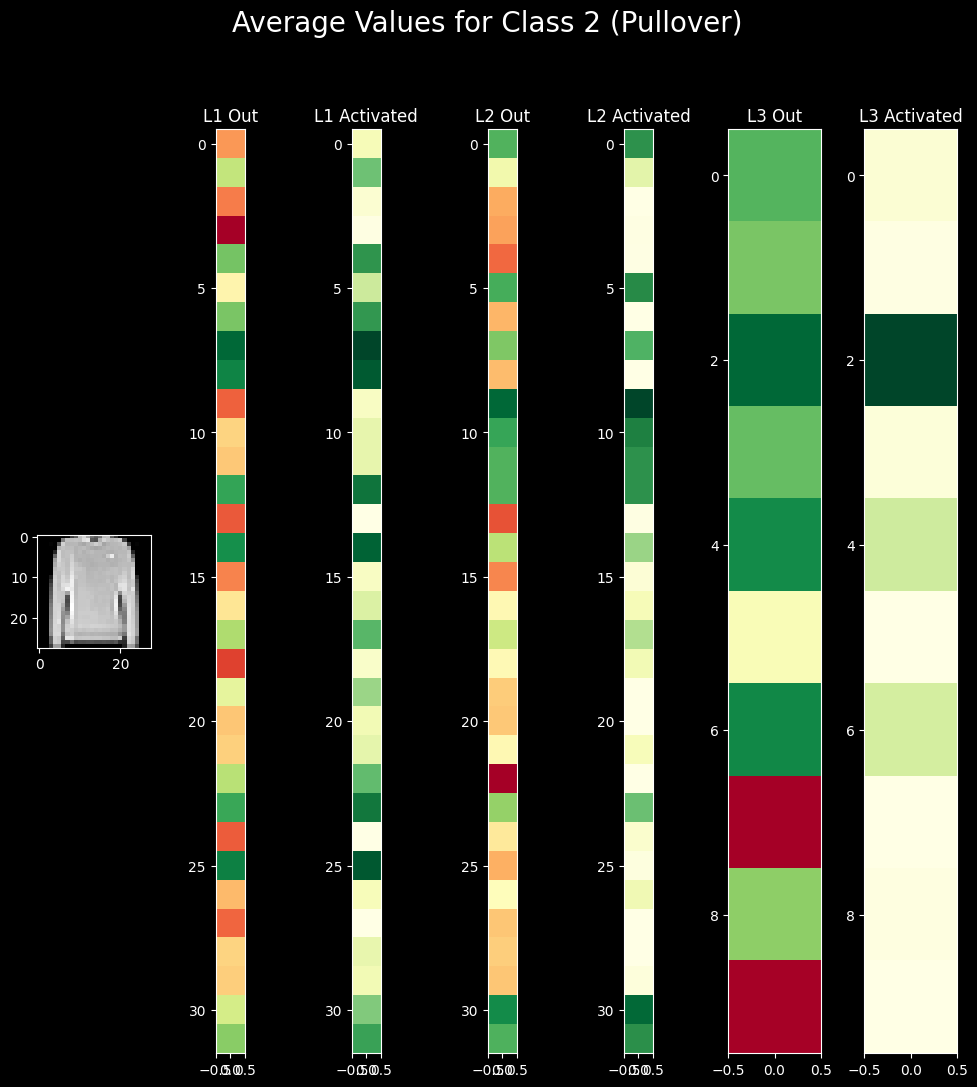

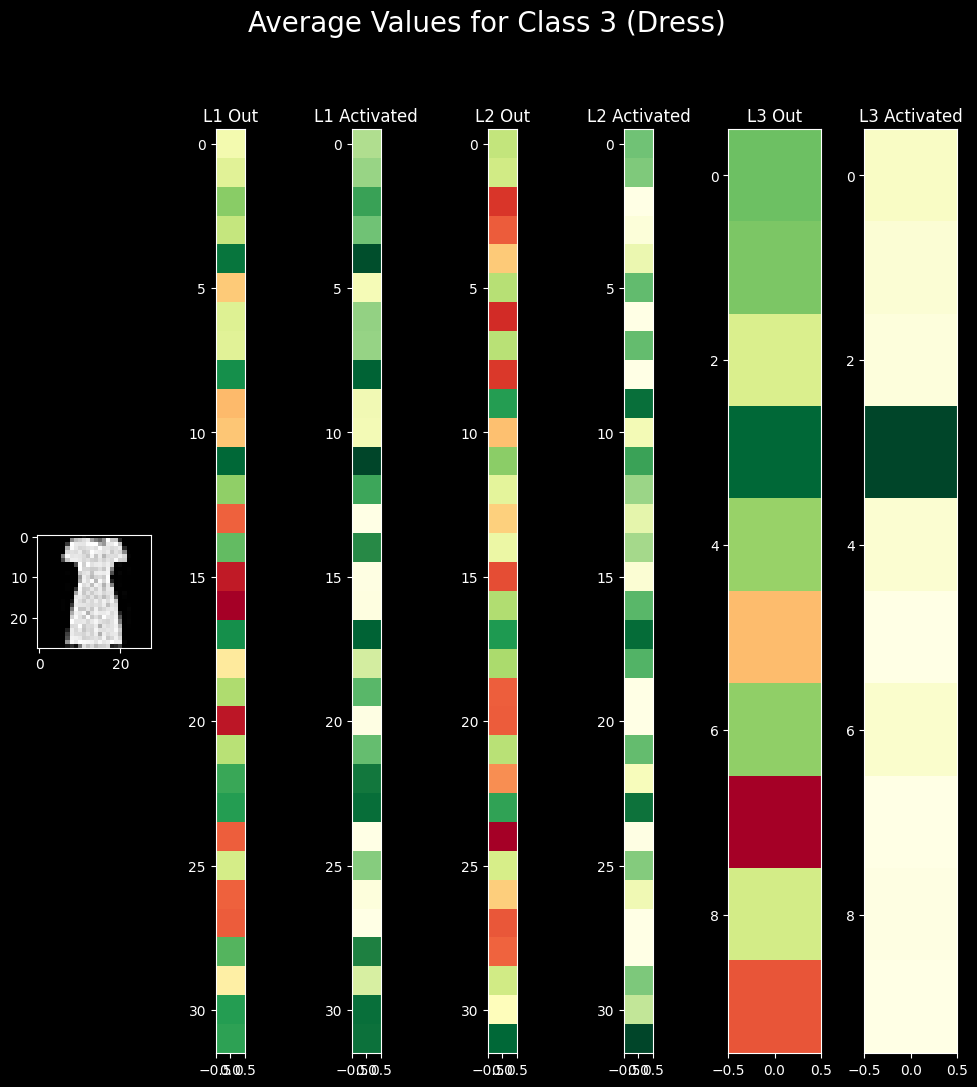

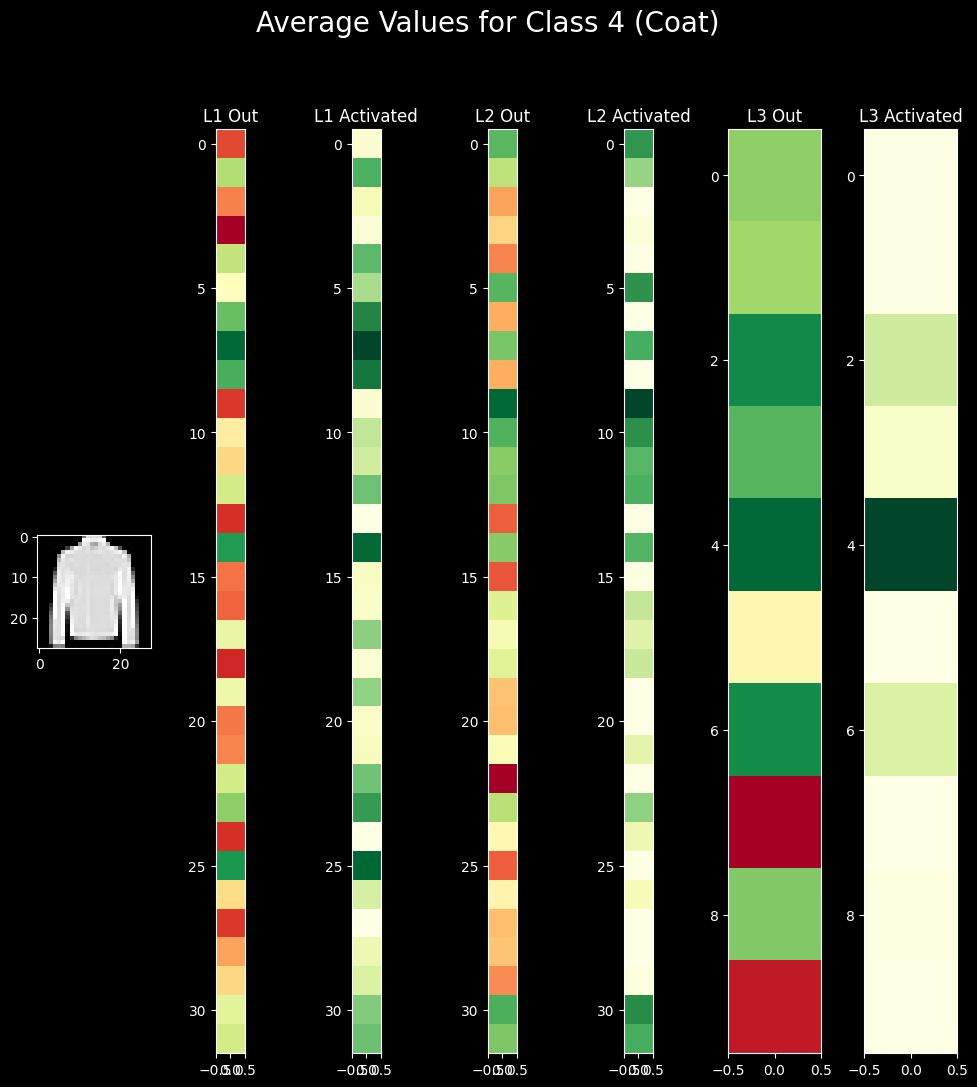

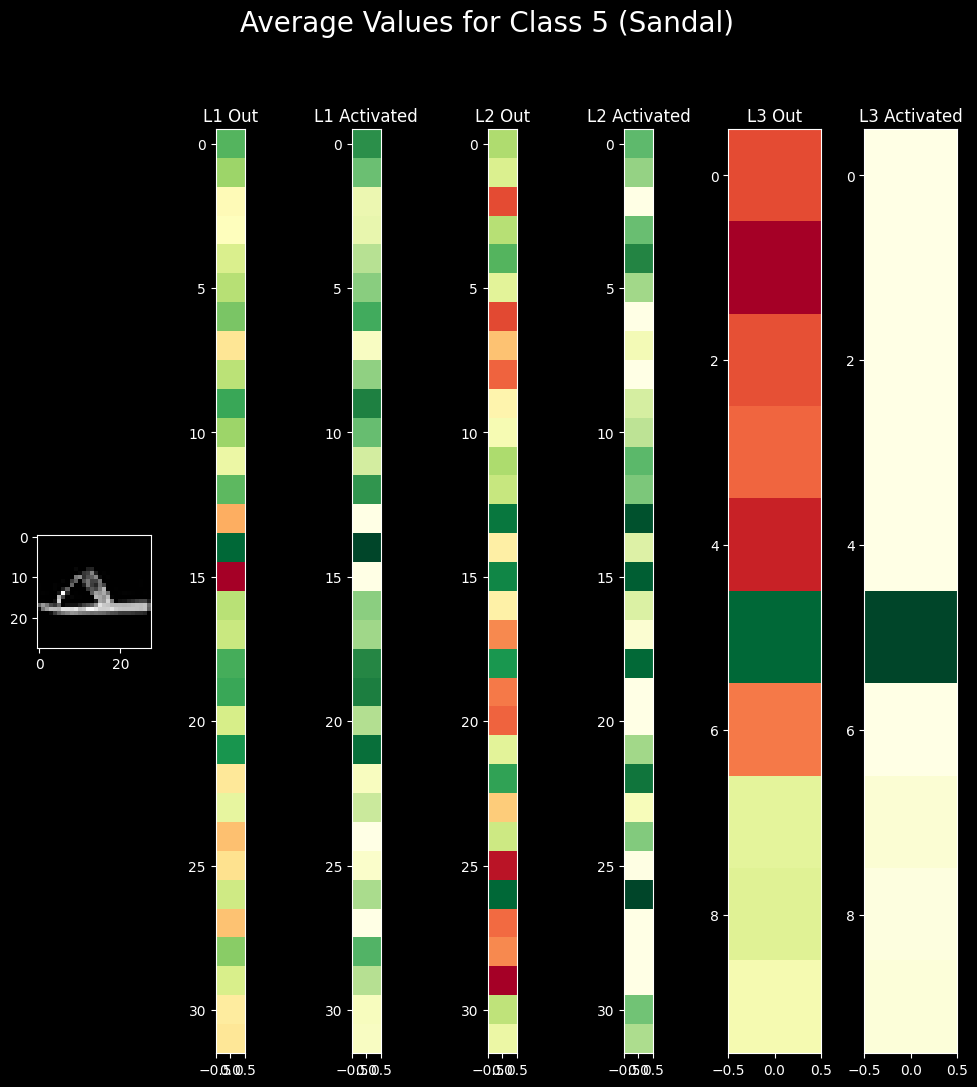

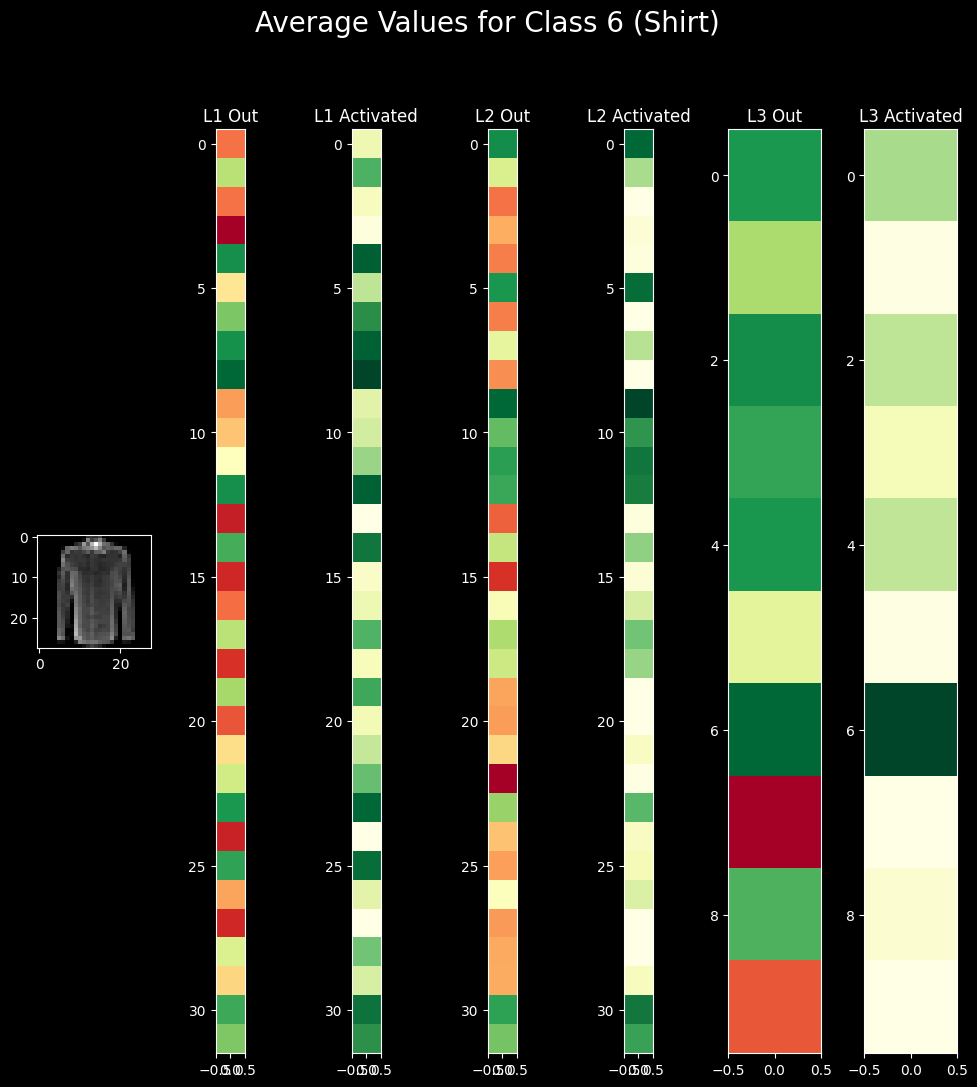

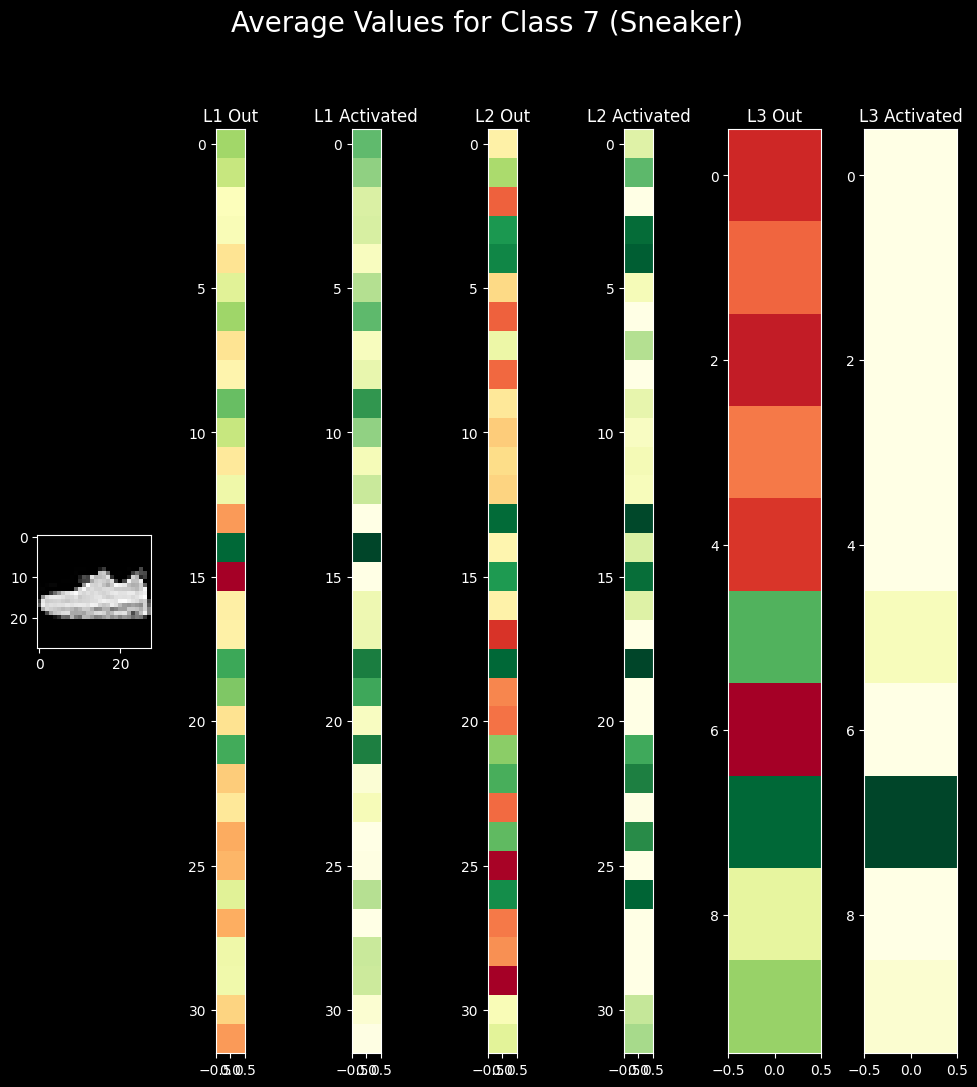

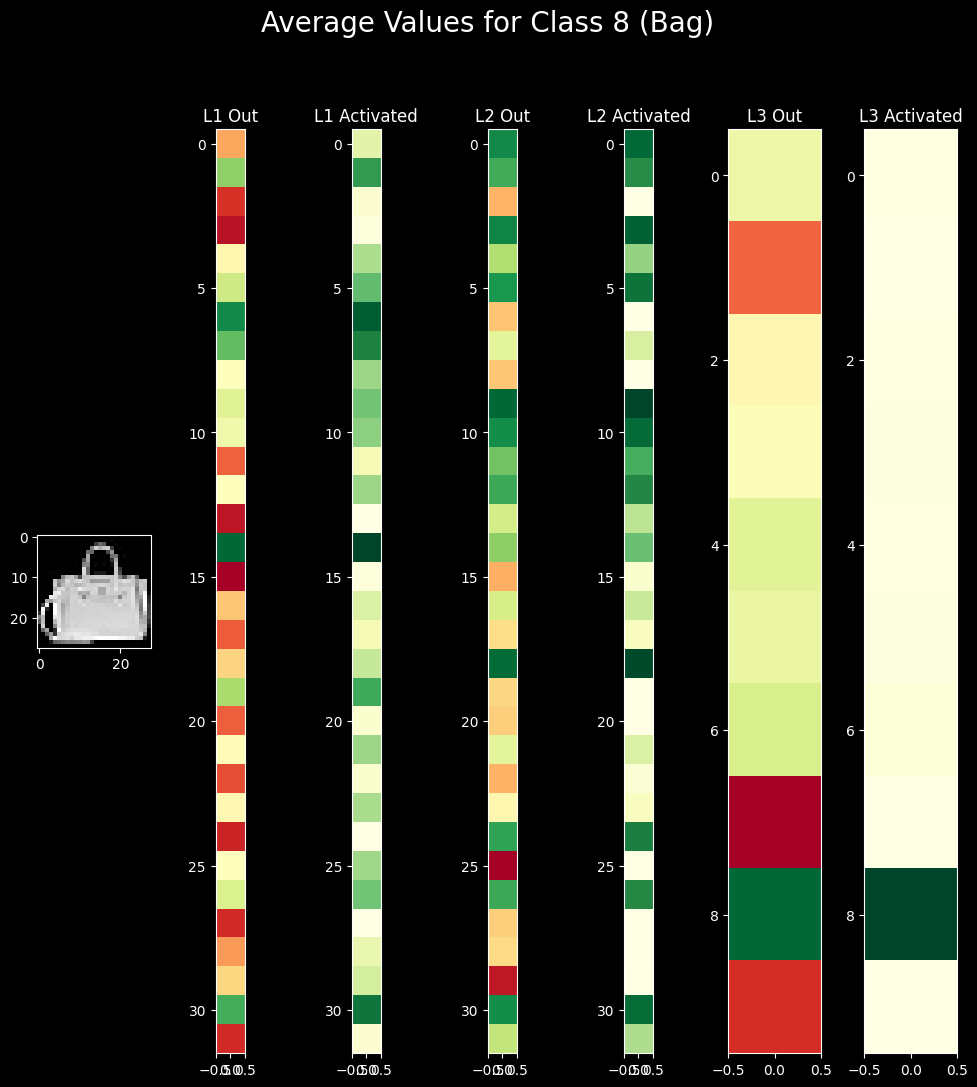

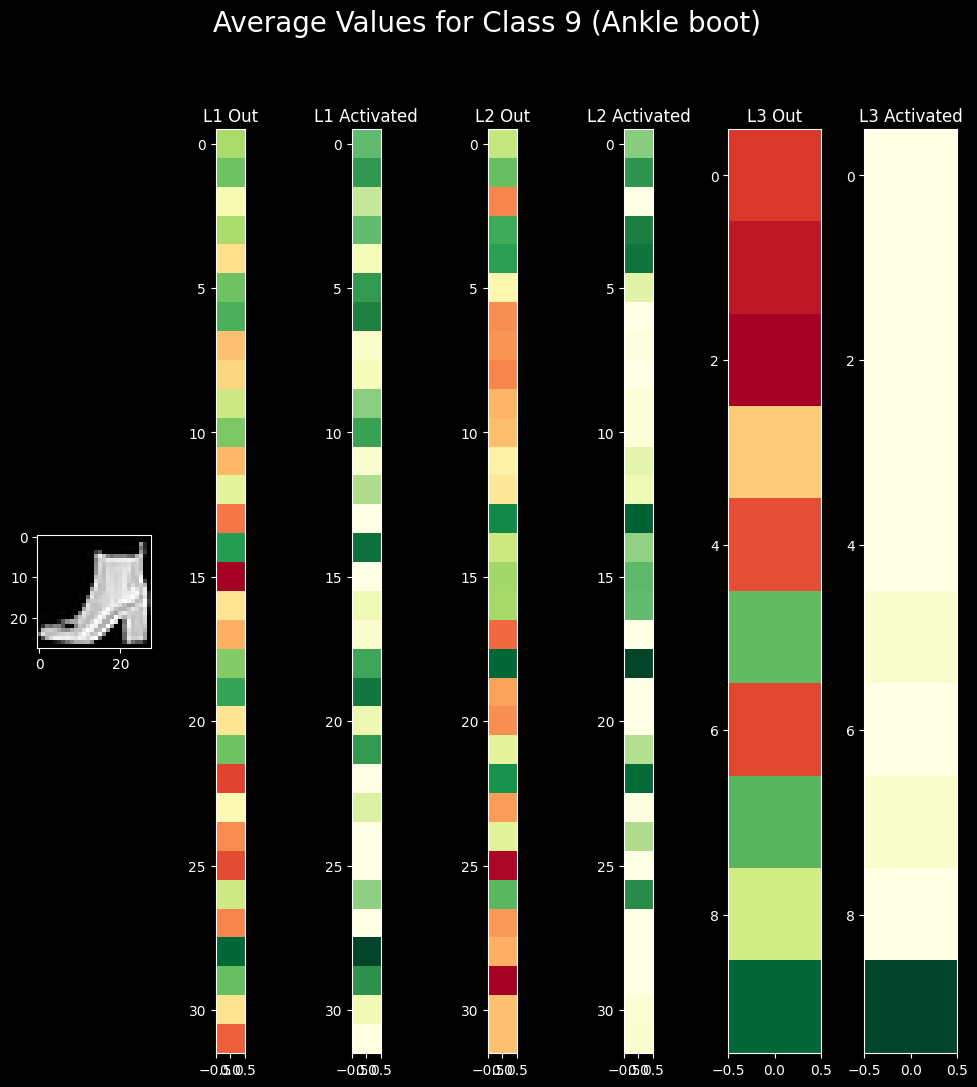

In [17]:
%matplotlib inline

dname = "class_avgs"
if not os.path.exists(dname):
    os.makedirs(dname)

style.use("dark_background")



class_sample_dict = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8:[], 9:[]}

# grab a single sample to represent the entire class
class_sample_dict[0] = X_test[3328]
class_sample_dict[1] = X_test[5215]
class_sample_dict[2] = X_test[501]
class_sample_dict[3] = X_test[9537]
class_sample_dict[4] = X_test[8533]
class_sample_dict[5] = X_test[7519]
class_sample_dict[6] = X_test[4213]
class_sample_dict[7] = X_test[1508]
class_sample_dict[8] = X_test[6217]
class_sample_dict[9] = X_test[2323]

class_description_dict = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}

for class_n in range(10):
    fig = plt.figure(figsize=(12, 12))
    fig.suptitle(f"Average Values for Class {class_n} ({class_description_dict[class_n]})",color="w", fontsize=20)

    ax0 = plt.subplot2grid((1,7), (0,0), rowspan=1, colspan=1)
    ax1 = plt.subplot2grid((1,7), (0,1), rowspan=1, colspan=1)
    ax2 = plt.subplot2grid((1,7), (0,2), rowspan=1, colspan=1)
    ax3 = plt.subplot2grid((1,7), (0,3), rowspan=1, colspan=1)
    ax4 = plt.subplot2grid((1,7), (0,4), rowspan=1, colspan=1)
    ax5 = plt.subplot2grid((1,7), (0,5), rowspan=1, colspan=1)
    ax6 = plt.subplot2grid((1,7), (0,6), rowspan=1, colspan=1)

    ax0.imshow(class_sample_dict[class_n].reshape(28, 28), cmap='gray')

    layer_1 = np.rot90(layer_data_by_class_averages[class_n][0], k=3, axes=(0,1))
    layer_1_activated = np.rot90(layer_data_by_class_averages[class_n][1], k=3, axes=(0,1))

    ax1.imshow(layer_1, cmap='RdYlGn')#, aspect='auto')
    ax2.imshow(layer_1_activated, cmap='YlGn')#, aspect='auto')

    ax1.set_title("L1 Out")
    ax2.set_title("L1 Activated")

    layer_2 = np.rot90(layer_data_by_class_averages[class_n][2], k=3, axes=(0,1))
    layer_2_activated = np.rot90(layer_data_by_class_averages[class_n][3], k=3, axes=(0,1))

    ax3.imshow(layer_2, cmap='RdYlGn')#, aspect='auto')
    ax4.imshow(layer_2_activated, cmap='YlGn')#, aspect='auto')

    ax3.set_title("L2 Out")
    ax4.set_title("L2 Activated")

    layer_3 = np.rot90(layer_data_by_class_averages[class_n][4], k=3, axes=(0,1))
    layer_3_activated = np.rot90(layer_data_by_class_averages[class_n][5], k=3, axes=(0,1))

    ax5.imshow(layer_3, cmap='RdYlGn')#, aspect='auto')
    ax6.imshow(layer_3_activated, cmap='YlGn')#, aspect='auto')

    ax5.set_title("L3 Out")
    ax6.set_title("L3 Activated")

    plt.savefig(f"class_avgs/{class_n}.png")

In [ ]:
%matplotlib tk

import pickle
import time

style.use("dark_background")

def make_plots():
    with open("train_dict.pkl", "rb") as f:
        train_dict = pickle.load(f)

    fig = plt.figure(figsize=(15, 5))
    ax0 = fig.add_subplot(131)
    ax1 = fig.add_subplot(132)
    ax2 = fig.add_subplot(133)

    epochs = 5

    for epoch in range(1, epochs+1):
        print("Epoch:", epoch)

        for step in train_dict[epoch]:
            if (step % 10) == 0:
                if step == 10: time.sleep(4)
                print('Step:', step)

                weights_0 = train_dict[epoch][step][0]["weights"]
                weights_1 = train_dict[epoch][step][1]["weights"]
                weights_2 = train_dict[epoch][step][2]["weights"]

                ax0.imshow(weights_0, cmap='RdYlGn')
                ax1.imshow(weights_1, cmap='RdYlGn')
                ax2.imshow(weights_2, cmap='RdYlGn')

                fig.suptitle(f"Mashion MNIST Weights - Epoch {epoch}, Step {step}", color="w", fontsize=20)

                ax0.set_title("Layer 1 weights\nin 784, out 32")
                ax1.set_title("Layer 2 weights\nin 32, out 32")
                ax2.set_title("Layer 3 weights\nin 32, out 10")

                ax0.title.set_fontsize(10)
                ax1.title.set_fontsize(10)
                ax2.title.set_fontsize(10)

                ax0.set_aspect(0.05)
                ax0.set_ylim(0,784)

                fig.set_size_inches(8,8)

                plt.pause(0.01)
                #fig.clear()
                ax0.clear()
                ax1.clear()
                ax2.clear()
    
    plt.show()

make_plots()